In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


# Loading the dataset

In [3]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [4]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Deeper Network (2 hidden layers)

To get from the perceptron to mlp we expanded the model with many parallel matrix operations. Now we can try to make it deeper, with more operations happening in series. <br>
This is especially poerful because biological neurons fire around 100 times a second, it takes a human 100ms to identify an object, so it stands to reason that a 10 layer network should be able to do complex tasks.  

Millions of parameters: 0.07
Epoch ___0 - Loss: 4.169
Epoch _300 - Loss: 2.788
Epoch _600 - Loss: 2.442
Epoch _900 - Loss: 2.232
Epoch 1200 - Loss: 2.125
Epoch 1500 - Loss: 2.051
Epoch 1800 - Loss: 1.997
Epoch 2100 - Loss: 1.980
Epoch 2400 - Loss: 1.908
Epoch 2700 - Loss: 1.850


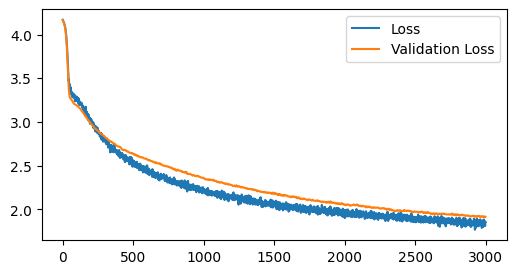

In [5]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Much deeper network (20 layers)

Millions of parameters: 0.37
Epoch ___0 - Loss: 4.160
Epoch _300 - Loss: 3.130
Epoch _600 - Loss: 2.688
Epoch _900 - Loss: 2.538
Epoch 1200 - Loss: 2.434
Epoch 1500 - Loss: 2.384
Epoch 1800 - Loss: 2.361
Epoch 2100 - Loss: 2.322
Epoch 2400 - Loss: 2.253
Epoch 2700 - Loss: 2.281


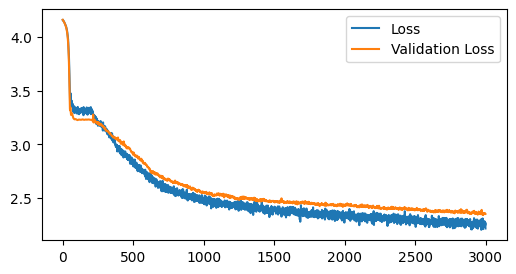

In [6]:
class Model(nn.Module):  # Same model class as before
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx:
            x = F.gelu(hidden(x))
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=20).to(device)  # increased to 20 layers 
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

The network with 20 hidden layers is unable to train effectively, thats because the derivatives don't flow well between the layers

# Residual connections

Millions of parameters: 0.37
Epoch ___0 - Loss: 5.947
Epoch _300 - Loss: 2.314
Epoch _600 - Loss: 1.971
Epoch _900 - Loss: 1.759
Epoch 1200 - Loss: 1.725
Epoch 1500 - Loss: 1.616
Epoch 1800 - Loss: 1.583
Epoch 2100 - Loss: 1.559
Epoch 2400 - Loss: 1.550
Epoch 2700 - Loss: 1.536


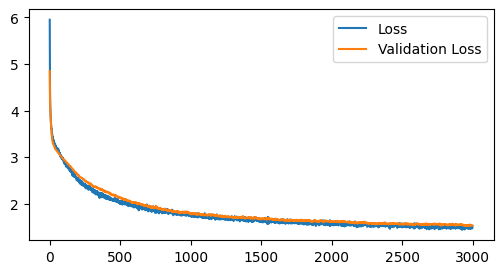

In [12]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = x + F.gelu(hidden(x))  # added skip connection 
        return self.fc2(x)
    

device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=20).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

# Deeper (56 layers) 

In [8]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = x + F.gelu(hidden(x))  
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=56).to(device)  # increased to 56 layers
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Millions of parameters: 0.96
Epoch ___0 - Loss: 16900.322
Epoch _300 - Loss: 3.370
Epoch _600 - Loss: 3.202
Epoch _900 - Loss: 3.053
Epoch 1200 - Loss: 2.975
Epoch 1500 - Loss: 2.856
Epoch 1800 - Loss: 2.755
Epoch 2100 - Loss: 2.701
Epoch 2400 - Loss: 2.634
Epoch 2700 - Loss: 2.502


# Normalization

deeper connections allow us to go up to crazy amounts of layers, but we instantly notice the unreasonably high loss at the start, we solved this problem before by decreasing the parameter values at initialization, but if we go down more we are going to get extremely low values. Restricting the flow of information through the network<br><br>
We want the information in the neurons to travel through the network while not getting blown out to crazy high values. To do that we can normalize the neurons with layernorm, so that std = 1 and mean = 0

(you might want to apply normalization only once in a while, not at every layer like this, but performance is similar so I'll just show this version)

Millions of parameters: 0.96
Epoch ___0 - Loss: 4.349
Epoch _300 - Loss: 2.060
Epoch _600 - Loss: 1.714
Epoch _900 - Loss: 1.570
Epoch 1200 - Loss: 1.519
Epoch 1500 - Loss: 1.481
Epoch 1800 - Loss: 1.458
Epoch 2100 - Loss: 1.455
Epoch 2400 - Loss: 1.403
Epoch 2700 - Loss: 1.334


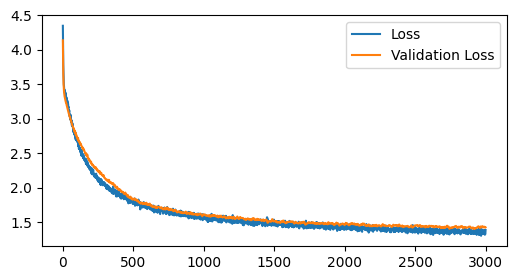

In [18]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.LayerNorm(hidden_size)  # added batch norm

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = self.norm(x + F.gelu(hidden(x)))  
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=56).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

In [19]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    model.eval()
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")
    model.train()


             
KING RICHARD II:
For what my report:
'Oether's dill, nor am revenge I strife in such inclot defer him.

TRANIO:
For scorn is hares and out mine each a very undertaki.

DORCIUS:
Away me of'd,
His no die;
For up the foe that villain thanksly Marcius
But lung thee; are done. But sall, sir? holting for Dowdarly, fort

# WAYY TOO DEEP
Just for fun lets try way more layers

In [ ]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) 
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.BatchNorm1d(hidden_size)  

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for hidden in self.fcx: 
            x = self.norm(x + F.gelu(hidden(x)))  
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model(emb_size=10, hidden_size=128, n_layers=200).to(device)  # increased to 200 layers
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Epoch ___0 - Loss: 4.236
Epoch _300 - Loss: 3.100
Epoch _600 - Loss: 2.821
Epoch _900 - Loss: 2.652
Epoch 1200 - Loss: 2.669
Epoch 1500 - Loss: 2.654
Epoch 1800 - Loss: 2.634
Epoch 2100 - Loss: 2.816
Epoch 2400 - Loss: 2.979
Epoch 2700 - Loss: 2.902


# Limits to scale
The model clearly has problems backpropagating the gradients effectively. You may be able to make it work with some weird trick but there are solutions that scale much better. 